In [1]:
import pandas as pd
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from multiprocessing import Pool, cpu_count
from matplotlib import patches, patheffects
import math

from fastai.dataset import *
from fastai.conv_learner import *

In [2]:
% load_ext autoreload
% autoreload 2
% matplotlib inline

In [3]:
from pathlib import Path

In [4]:
ddir = "/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge"

In [5]:
rsna_path = Path(ddir)

In [6]:
detailed_class_info_csv = pd.read_csv(rsna_path/'stage_1_detailed_class_info.csv')

In [7]:
stage_1_sample_submission_csv = pd.read_csv(rsna_path/'stage_1_sample_submission.csv')

In [8]:
stage_1_train_labels_csv = pd.read_csv(rsna_path/'stage_1_train_labels.csv')

In [9]:
train_images = list((rsna_path/'train/').glob('*.dcm'))

In [81]:
# First step to open dcm files

In [13]:
ds = pydicom.dcmread(str(train_images[0]))

In [12]:
# dir(ds)

In [15]:
# ds.PatientAge

In [14]:
# ds.pixel_array

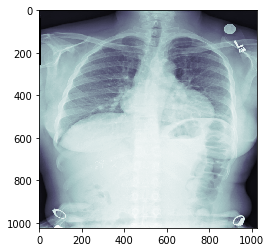

In [16]:
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)

'b215a2cf-ddf6-4032-99a0-1c2b10ef2f9e'

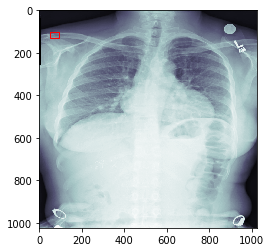

In [17]:
# Show a Bounding Box
fig, ax = plt.subplots(1)
ax.imshow(ds.pixel_array, cmap=plt.cm.bone)
rect = Rectangle((50,100),40,30,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ds.PatientID

In [18]:
stage_1_train_labels_csv[:10]

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [17]:
stage_1_train_labels_csv[stage_1_train_labels_csv['patientId'] == 'b215a2cf-ddf6-4032-99a0-1c2b10ef2f9e']

,patientId,x,y,width,height,Target
19064,b215a2cf-ddf6-4032-99a0-1c2b10ef2f9e,NaN,NaN,NaN,NaN,0


In [19]:
def get_ds_file(file):
    ds = pydicom.dcmread(str(file))
    return {
        'file': str(file).split('/')[-1].split('.dcm')[0],
        'ds': ds
    }

In [20]:
train_images_map = list(map(get_ds_file, train_images))

In [21]:
def find_by_id(id):
    return list(filter(lambda x: x['file'] == id, train_images_map))

In [16]:
find_by_id('b215a2cf-ddf6-4032-99a0-1c2b10ef2f9e')[0]['ds'].pixel_array

array([[177,  56,  38, ...,  18,  18,  18],
       [ 97,  41,  37, ...,  21,  21,  21],
       [ 42,  35,  28, ...,  22,  22,  22],
       ..., 
       [185, 176, 169, ...,  16,  16,  16],
       [191, 183, 175, ...,  16,  16,  16],
       [197, 188, 181, ...,  16,  16,  17]], dtype=uint8)

In [22]:
def select_by_id(id):
    return stage_1_train_labels_csv[stage_1_train_labels_csv['patientId'] == id]

In [24]:
def show_img_by_id(id):
    ds = find_by_id(id)[0]['ds']
    pixel_array = find_by_id(id)[0]['ds'].pixel_array
    fig, ax = plt.subplots(1)
    ax.imshow(ds.pixel_array, cmap=plt.cm.bone)
    
    _, x, y, width, height, _  = select_by_id(id).iloc[0]
    rect = Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

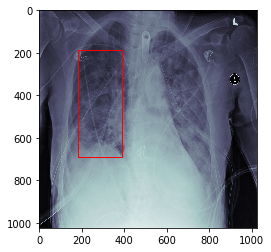

In [25]:
show_img_by_id('00f08de1-517e-4652-a04f-d1dc9ee48593')

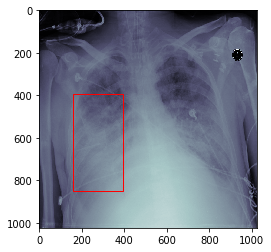

In [26]:
show_img_by_id('ffd787b6-59ca-48cb-bd15-bcedd52cf37c')

In [35]:
len(train_images_map)

25684

In [201]:
metrics = []

In [202]:
not_nan_values = stage_1_train_labels_csv[~np.isnan(stage_1_train_labels_csv['width'])]

#### of train dataset 8964 / 25684 samples are not NaN 34%

In [203]:
len(not_nan_values)

8964

In [189]:
sample_labels = stage_1_train_labels_csv[0:1000]

In [204]:
8964 / 25684

0.3490110574676842

In [191]:
n_sample = len(sample_labels); n_sample

1000

In [205]:
not_nan_samples = sample_labels[~np.isnan(sample_labels['width'])]

In [200]:
len(not_nan_samples)

428

In [206]:
not_nan_samples

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1
15,00aecb01-a116-45a2-956c-08d2fa55433f,547.0,299.0,119.0,165.0,1
16,00c0b293-48e7-4e16-ac76-9269ba535a62,306.0,544.0,168.0,244.0,1
17,00c0b293-48e7-4e16-ac76-9269ba535a62,650.0,511.0,206.0,284.0,1
19,00f08de1-517e-4652-a04f-d1dc9ee48593,181.0,184.0,206.0,506.0,1
20,00f08de1-517e-4652-a04f-d1dc9ee48593,571.0,275.0,230.0,476.0,1


In [27]:
PNG_PATH = '/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/train_png/'

In [28]:
fmodel = resnet34
sz = 224
bs = 64

In [29]:
tfms = tfms_from_model(fmodel, sz, crop_type=CropType.NO)

In [118]:
?? ImageClassifierData.from_csv

In [27]:
# save_as_png(train_images[0])

In [49]:
def save_as_png(file):
    key = str(file).split('/')[-1].split('.dcm')[0]
    ds = pydicom.dcmread(str(file))
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    png_path = f"{PNG_PATH}{key}.png"
    if os.path.isfile(png_path) and os.access(png_path, os.R_OK):
        print("FILE EXISTS. SKIPPING")
    else:
        plt.savefig(png_path)

In [28]:
# list(map(save_as_png, train_images))

In [29]:
 # p = Pool(64)

In [30]:
# p.map(save_as_png, train_images)

In [36]:
PNG_PATH

'/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/train_png/'

In [38]:
! ls {PNG_PATH} -l | wc -l

25621


In [42]:
png_list = list(Path(PNG_PATH).glob('*.png'))

In [44]:
len(train_images)

25684

In [43]:
len(png_list)

25620

In [29]:
def get_key(file):
    key = str(file).split("/")[-1].split('.')[0]
    return str(key).strip()

In [34]:
# png_keys = list(map(get_key, png_list))

In [35]:
# keys = list(map(get_key, train_images))

In [36]:
# keys

In [37]:
# png_keys[0] not in keys

In [38]:
# missing_keys = [key for key in keys if key not in png_keys]

In [39]:
# len(missing_keys)

In [112]:
f"/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/train/{missing_keys[0]}.dcm"

'/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/train/a4cba60f-6006-4a32-8ce7-488fa06bec4c.dcm'

In [115]:
def save_as_missing_png(key):
    file = f"/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/train/{key}.dcm"
    ds = pydicom.dcmread(str(file))
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    png_path = f"{PNG_PATH}{key}.png"
    if os.path.isfile(png_path) and os.access(png_path, os.R_OK):
        print("FILE EXISTS. SKIPPING")
    else:
        print(f"SAVING FILE - {key}")
        plt.savefig(png_path)

SAVING FILE - a4cba60f-6006-4a32-8ce7-488fa06bec4c
SAVING FILE - 964a7f12-5f17-4250-aa48-ecbe33d5409d
SAVING FILE - de467a03-bbd1-4467-a707-e1c8f00f085c
SAVING FILE - 643b5c88-3f21-4d40-90cb-bc0caa562e18
SAVING FILE - 3cf312c7-2d29-463b-bcc2-2a7e074d1d06
SAVING FILE - a98c1f37-66a6-4670-add8-44dfcac0fc77
SAVING FILE - 5bd84e26-fe41-4661-8fe6-d443473e4914
SAVING FILE - 327af298-ff3a-44b9-b5bf-93ab3a5abb04
SAVING FILE - 635058f5-90a8-46b6-8c4c-0989a3a82afb
SAVING FILE - 5cdd56f1-9ad7-4b45-81e2-6f5c0a890cec
SAVING FILE - 783d1dfc-ece5-4b84-8da5-dc836ae869a9
SAVING FILE - 93a855fc-2b35-4acc-8cdd-2f15f888bfc7
SAVING FILE - dba66bd1-9e64-46d8-b85e-68ed1e47e0d4
SAVING FILE - a4648b6c-713a-4c72-a126-1115ec122e27
SAVING FILE - e5344229-9a8e-4734-b5d2-1c2dcec9d047
SAVING FILE - 7b561dcf-cbb8-45d8-a144-34ce39dfddfd
SAVING FILE - 55e388bc-efbc-4116-bbda-3207e82e4c45
SAVING FILE - 383d8991-e27b-4f43-bab1-e1f492ace0f5
SAVING FILE - c69f7bdb-52dc-4b81-b04d-2cb955be56d7
SAVING FILE - 6bc9eb57-6fcd-468

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

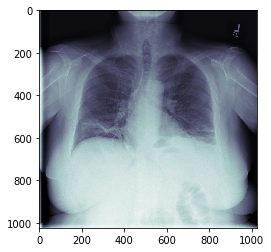

In [116]:
list(map(save_as_missing_png, missing_keys))

In [117]:
# Start Work on Classifier

In [44]:
patient_ids = stage_1_train_labels_csv.patientId.values.tolist()

In [45]:
target_values = stage_1_train_labels_csv.Target.values.tolist()

In [26]:
CSV = "../tmp/rsna.csv"

In [27]:
df = pd.DataFrame({'fn': patient_ids, 'cat': target_values}, columns=['fn', 'cat'])

In [28]:
df.to_csv(CSV, index=False)

In [56]:
rsna_path
image_path = "train_png"

In [30]:
md = ImageClassifierData.from_csv(rsna_path, image_path, CSV, tfms=tfms, bs=bs, suffix='.png')

In [140]:
len(stage_1_train_labels_csv)

28989

In [155]:
# list(map(lambda x: f"{x}.png" , patient_ids))

In [33]:
x, y = next(iter(md.val_dl))

In [188]:
?? ImageClassifierData.from_csv(rsna_path, image_path, CSV, tfms=tfms, bs=bs)

In [31]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

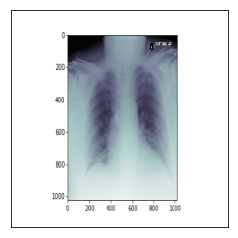

In [34]:
show_img(md.val_ds.denorm(to_np(x))[3])

In [35]:
learn = ConvLearner.pretrained(fmodel, md)

In [36]:
learn.opt_fn = optim.Adam

In [60]:
lrf = learn.lr_find(1e-5, 100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 66%|██████▌   | 238/363 [01:13<00:38,  3.25it/s, loss=2.13] 

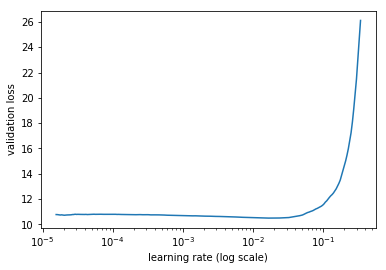

In [207]:
learn.sched.plot()

In [71]:
y

tensor([ 0,  0,  1,  0,  0,  0,  0,  1,  1,  1,  0,  1,  1,  1,
         0,  0,  1,  1,  0,  0,  1,  1,  0,  0,  1,  1,  0,  0,
         0,  0,  1,  0,  1,  1,  0,  0,  0,  0,  0,  0,  1,  1,
         1,  1,  0,  1,  0,  1,  0,  0,  1,  1,  0,  1,  1,  1,
         1,  1,  1,  1,  0,  0,  1,  0], device='cuda:0')

In [61]:
lr = 1e-1

In [85]:
learn.fit(lr, 3, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.494435   0.450759   0.779886  
    1      0.436724   0.427877   0.799896                    
    2      0.527145   0.436867   0.792479                    
    3      0.433429   0.555493   0.797999                    
    4      0.627412   1.335958   0.791271                    
    5      0.43734    0.44232    0.795066                    



[0.44232012737366955, 0.79506641362111119]

In [87]:
learn.save('rsna_model_weights_09082018.pth')

In [37]:
learn.load('rsna_model_weights_09082018.pth')

In [69]:
next()md.val_dl

In [68]:
?? learn.predict()

In [38]:
log_preds = learn.predict()

In [76]:
log_preds[:10]

array([[-0.01779, -4.03811],
       [-0.3339 , -1.25921],
       [-2.2978 , -0.10589],
       [-0.06738, -2.73085],
       [-0.15019, -1.97002],
       [-0.02715, -3.61982],
       [-0.14129, -2.02679],
       [-0.61055, -0.78319],
       [-0.6878 , -0.69852],
       [-0.56142, -0.8449 ]], dtype=float32)

In [75]:
log_preds[:10][0]

array([-0.01779, -4.03811], dtype=float32)

In [39]:
preds = np.argmax(log_preds, axis=1)

In [40]:
preds

array([0, 0, 1, ..., 0, 1, 1])

In [91]:
md.val_ds.y

array([0, 0, 1, ..., 0, 1, 0])

In [34]:
stage_1_train_labels_csv.Target.values.tolist()

[0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,


In [40]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [41]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [101]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f42a7d96b70> (for post_execute):


TypeError: float() argument must be a string or a number, not 'tuple'

TypeError: float() argument must be a string or a number, not 'tuple'

In [103]:
# BB CSV

In [104]:
detailed_class_info_csv[:10]

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


In [105]:
stage_1_train_labels_csv[:10]

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [119]:
import pdb

In [42]:
def get_bb(row):
    row[2:5]
    x = row[1]
    if math.isnan(float(x)):
        return "0 0 0 0"
    y = row[2]
    width = row[3]
    height = row[4]
    return f"{x} {y} {width} {height}"

In [61]:
v1 = stage_1_train_labels_csv.values.tolist()[0]

In [62]:
get_bb(v1)

'0 0 0 0'

In [43]:
bbox = list(map(get_bb, stage_1_train_labels_csv.values.tolist()))

In [49]:
BBOX_CSV = "../tmp/rsna_bbox.csv"
df = pd.DataFrame({'fn': patient_ids, 'bbox': bbox}, columns=['fn', 'bbox'])
df.to_csv(BBOX_CSV, index=False)

In [62]:
BBOX_CSV_SAMPLE = "../tmp/rsna_bbox_sample.csv"
df = pd.DataFrame({'fn': patient_ids, 'bbox': bbox}, columns=['fn', 'bbox'])
df = df[df['bbox']!= "0 0 0 0"]
df = df[:1000]
df.to_csv(BBOX_CSV_SAMPLE, index=False)

In [64]:
f_model=resnet34
sz=224
bs=64

In [65]:
augs = [RandomFlip(), 
        RandomRotate(30),
        RandomLighting(0.1,0.1)]

In [57]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs)
md = ImageClassifierData.from_csv(rsna_path, image_path, BBOX_CSV, tfms=tfms, continuous=True, bs=4, suffix='.png')

In [66]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs)
md = ImageClassifierData.from_csv(rsna_path, image_path, BBOX_CSV_SAMPLE, tfms=tfms, continuous=True, bs=4, suffix='.png')

In [67]:
md.val_ds.y

array([[ 703.,  416.,   84.,   77.],
       [ 225.,  415.,   98.,  101.],
       [ 714.,  278.,  255.,  576.],
       [ 664.,  380.,  141.,  330.],
       [ 669.,  449.,  162.,  284.],
       [ 617.,  269.,  208.,  420.],
       [ 616.,  306.,  180.,  475.],
       [ 616.,  306.,  180.,  475.],
       [ 239.,  352.,  121.,   93.],
       [ 610.,  599.,  265.,  245.],
       [ 210.,  396.,  182.,  493.],
       [ 284.,  170.,  215.,  571.],
       [ 591.,  242.,  187.,  333.],
       [ 185.,  408.,  188.,  307.],
       [ 637.,  240.,  242.,  547.],
       [ 381.,  613.,  108.,  162.],
       [ 349.,  735.,  173.,  172.],
       [ 160.,  264.,  317.,  501.],
       [ 259.,  499.,  202.,  269.],
       [ 563.,  619.,  334.,  241.],
       [ 459.,  246.,  351.,  645.],
       [ 275.,  194.,  307.,  498.],
       [ 581.,  382.,  313.,  223.],
       [ 467.,  218.,  298.,  545.],
       [  87.,  414.,  241.,  201.],
       [  87.,  414.,  241.,  201.],
       [ 152.,  383.,  215.,  240.],
 

In [68]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [72]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape

In [70]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape

In [69]:
learn.lr_find(1e-5, 100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 74%|███████▍  | 149/200 [00:04<00:01, 30.75it/s, loss=693]


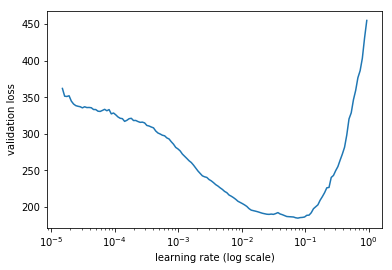

In [70]:
learn.sched.plot(5)

In [81]:
lr = 1e-2

In [82]:
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 90%|█████████ | 180/200 [00:04<00:00, 36.16it/s, loss=147]

Exception in thread Thread-14:
Traceback (most recent call last):
  File "/home/edwin/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/edwin/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/edwin/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                             
    0      145.950032 145.508919
    1      137.139441 139.244507                           
    2      127.852708 134.557723                           



[134.55772323608397]

In [83]:
learn.save('reg4')

In [84]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

In [85]:
preds

array([[ 573.35748,  334.98987,   25.22275,  262.4238 ],
       [ 586.78247,  199.12825,  114.48227,  533.25287],
       [ 710.55042,   82.5449 ,  261.26758,  608.70782],
       [ 156.58075,  763.56909,  171.48364,  354.99442]], dtype=float32)

In [86]:
y

tensor([[ 703.,  416.,   84.,   77.],
        [ 225.,  415.,   98.,  101.],
        [ 714.,  278.,  255.,  576.],
        [ 664.,  380.,  141.,  330.]], device='cuda:0')

In [75]:
md.val_ds.y[:4]

array([[ 703.,  416.,   84.,   77.],
       [ 225.,  415.,   98.,  101.],
       [ 714.,  278.,  255.,  576.],
       [ 664.,  380.,  141.,  330.]], dtype=float32)

In [88]:
idx

NameError: name 'idx' is not defined

In [89]:
ima = md.val_ds.ds.denorm(to_np(x))[3]

AttributeError: 'FilesIndexArrayRegressionDataset' object has no attribute 'ds'

In [95]:
preds[0]

array([ 47.03142,  38.37902,  23.57978,  38.64782], dtype=float32)

In [96]:
x[0]

tensor([[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
           2.2489e+00,  2.2489e+00],
         [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
           2.2489e+00,  2.2489e+00],
         [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
           2.2489e+00,  2.2489e+00],
         ...,
         [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
           2.2489e+00,  2.2489e+00],
         [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
           2.2489e+00,  2.2489e+00],
         [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
           2.2489e+00,  2.2489e+00]],

        [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
           2.4286e+00,  2.4286e+00],
         [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
           2.4286e+00,  2.4286e+00],
         [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
           2.4286e+00,  2.4286e+00],
         ...,
         [ 2.4286e+00,  2

In [99]:
preds[3]

array([ 38.93356,  43.91233,  42.31933,  44.09192], dtype=float32)

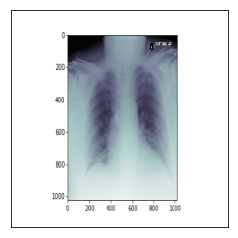

In [98]:
show_img(md.val_ds.denorm(to_np(x))[3])

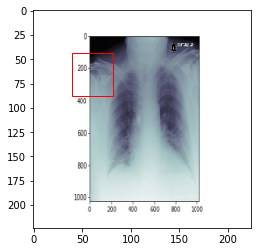

In [103]:
fig, ax = plt.subplots(1)
ax.imshow(ima, cmap=plt.cm.bone)
_x, _y, _width, _height = preds[3]
rect = Rectangle((_x,_y),_width,_height,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

In [101]:
ima = md.val_ds.denorm(to_np(x))[3]